# Machine Learning for CICY 3-Folds

We compute the Hodge numbers of CICY 3-folds using deep learning techniques inspired by the Inception architecture by Google.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import tarfile
import urllib
import json
import joblib
from IPython.display import Image
from nntools import *

In [2]:
random_state = 123
np.random.seed(random_state)
tf.random.set_seed(random_state)

## Create a Saving Directory

Each model will be assigned to a different directory based on the time of running.

In [3]:
img_dir, mod_dir = dir_struct('inception_h11_2d_small_outliers', dirs=['img', 'models'])

Current working directories:

  ./img/inception_h11_2d_small_outliers_20201222_095735
  ./models/inception_h11_2d_small_outliers_20201222_095735


## Load the Dataset

We then download the JSON file containing the configuration matrix and the Hodge numbers of the CICY.

In [4]:
os.makedirs('./data', exist_ok=True)

urllib.request.urlretrieve('http://www.lpthe.jussieu.fr/~erbin/files/data/cicy3o_data.tar.gz', './data/cicy3o_data.tar.gz')
with tarfile.open('./data/cicy3o_data.tar.gz', 'r') as tar:
    tar.extract('cicy3o.h5', path='./data')

In [5]:
df, (n_rows, n_cols) = load_hdf('./data/cicy3o.h5')

Size of the dataset: 7890 rows, 31 columns.


We then select only the non product spaces:

In [6]:
df = df.loc[df['isprod'] == False]

We the pad the matrix to get the same size for all configuration matrices:

In [7]:
max_size = df['matrix'].apply(np.shape).max()

df.loc[:, 'matrix'] = df['matrix'].apply(lambda x: np.pad(x, ((0, max_size[0] - np.shape(x)[0]), (0, max_size[1] - np.shape(x)[1]))))
df = df[['h11', 'h21', 'matrix']]
n_rows, n_cols = df.shape

In [8]:
num_classes = (int(df['h11'].max() + 1), int(df['h21'].max() + 1))

We then split it into train, validation and test sets:

In [9]:
df_splits = {'train': 0.3, 'val': 0.1, 'test': 0.1}
with open(os.path.join(mod_dir, 'train_ratio.json'), 'w') as f:
    json.dump(df_splits, f)

# split the sets
(df_train, df_val, df_test), (n_train, n_val, n_test) = train_test(df, df_splits, random_state=random_state)

In [10]:
del df

## Outliers in the Training Set

We then study the outliers in the training set:

In [11]:
# remove outliers
#df_train = df_train.loc[(df_train['h11'] >= 1) & (df_train['h11'] <= 16)
#                        &
#                        (df_train['h21'] >= 15) & (df_train['h21'] <= 86)
#                       ]
#n_train_pruned = df_train.shape[0]

In [12]:
#print(f'Samples removed: {n_train - n_train_pruned:d} ({100 * (n_train - n_train_pruned) / n_train:.2f}% of the training set, {100 * (n_train - n_train_pruned) / n_rows:.2f}% of the total set)')

## Rescale the Matrices

We then rescale the matrices in the sets to improve the deep learning results:

In [13]:
# rescaling = {'min': df_train['matrix'].apply(lambda x: np.min(x)).min(),
#              'max': df_train['matrix'].apply(lambda x: np.max(x)).max()
#             }
rescaling = None

## Feature and Label Creation

We then create the features and the labels.

In [14]:
reshape = df_train['matrix'].apply(np.shape).max() + (1,)

In [15]:
X_train = create_features(df_train['matrix'], rescaling=rescaling, reshape=reshape)
X_val   = create_features(df_val['matrix'], rescaling=rescaling, reshape=reshape)
X_test  = create_features(df_test['matrix'], rescaling=rescaling, reshape=reshape)

In [16]:
y_train = create_labels(df_train[['h11']], one_hot=True, num_classes=num_classes[0])
y_val   = create_labels(df_val[['h11']], one_hot=True, num_classes=num_classes[0])
y_test  = create_labels(df_test[['h11']], one_hot=True, num_classes=num_classes[0])

In [17]:
del df_train, df_val, df_test

## Inception Model

We then start to build the Inception model to be trained on the configuration matrices.

### Build the Model

In [18]:
model_data = {'input_shape':      reshape,
              'name':             'matrix',
              'learning_rate':    1.0e-3,
              'output_names':     'h11',
              'output_size':      num_classes[0],
              'model_type':       'classification',
              'inception_kernel': [(3,3), (5,5)],
              'conv_1b1':         False,
              'conv_layers':      [32, 64, 32],
              'conv_alpha':       0.0,
              'conv_class':       None,
              'conv_single':      False,
              'conv_red':         0,
              'feat_map':         0,
              'recurrent':        False,
              'fc_layers':        [],
              'fc_alpha':         0.0,
              'dropout':          0.2,
              'full_dropout':     0.0,
              'batchnorm':        0.99,
              'last_relu':        False,
              'loss_weights':     None,
              'l1_reg':           1.0e-4,
              'l2_reg':           1.0e-3,
              'output_layers':    True,
              'random_state':     random_state
             }

with open(os.path.join(mod_dir, 'model_data.json'), 'w') as f:
    json.dump(model_data, f)

In [19]:
inception = nn_inception(**model_data)
inception.summary()

Model: "matrix"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
matrix (InputLayer)             [(None, 12, 15, 1)]  0                                            
__________________________________________________________________________________________________
matrix_convAa_0 (Conv2D)        (None, 12, 15, 32)   320         matrix[0][0]                     
__________________________________________________________________________________________________
matrix_convAb_0 (Conv2D)        (None, 12, 15, 32)   832         matrix[0][0]                     
__________________________________________________________________________________________________
matrix_actAa_0 (LeakyReLU)      (None, 12, 15, 32)   0           matrix_convAa_0[0][0]            
_____________________________________________________________________________________________

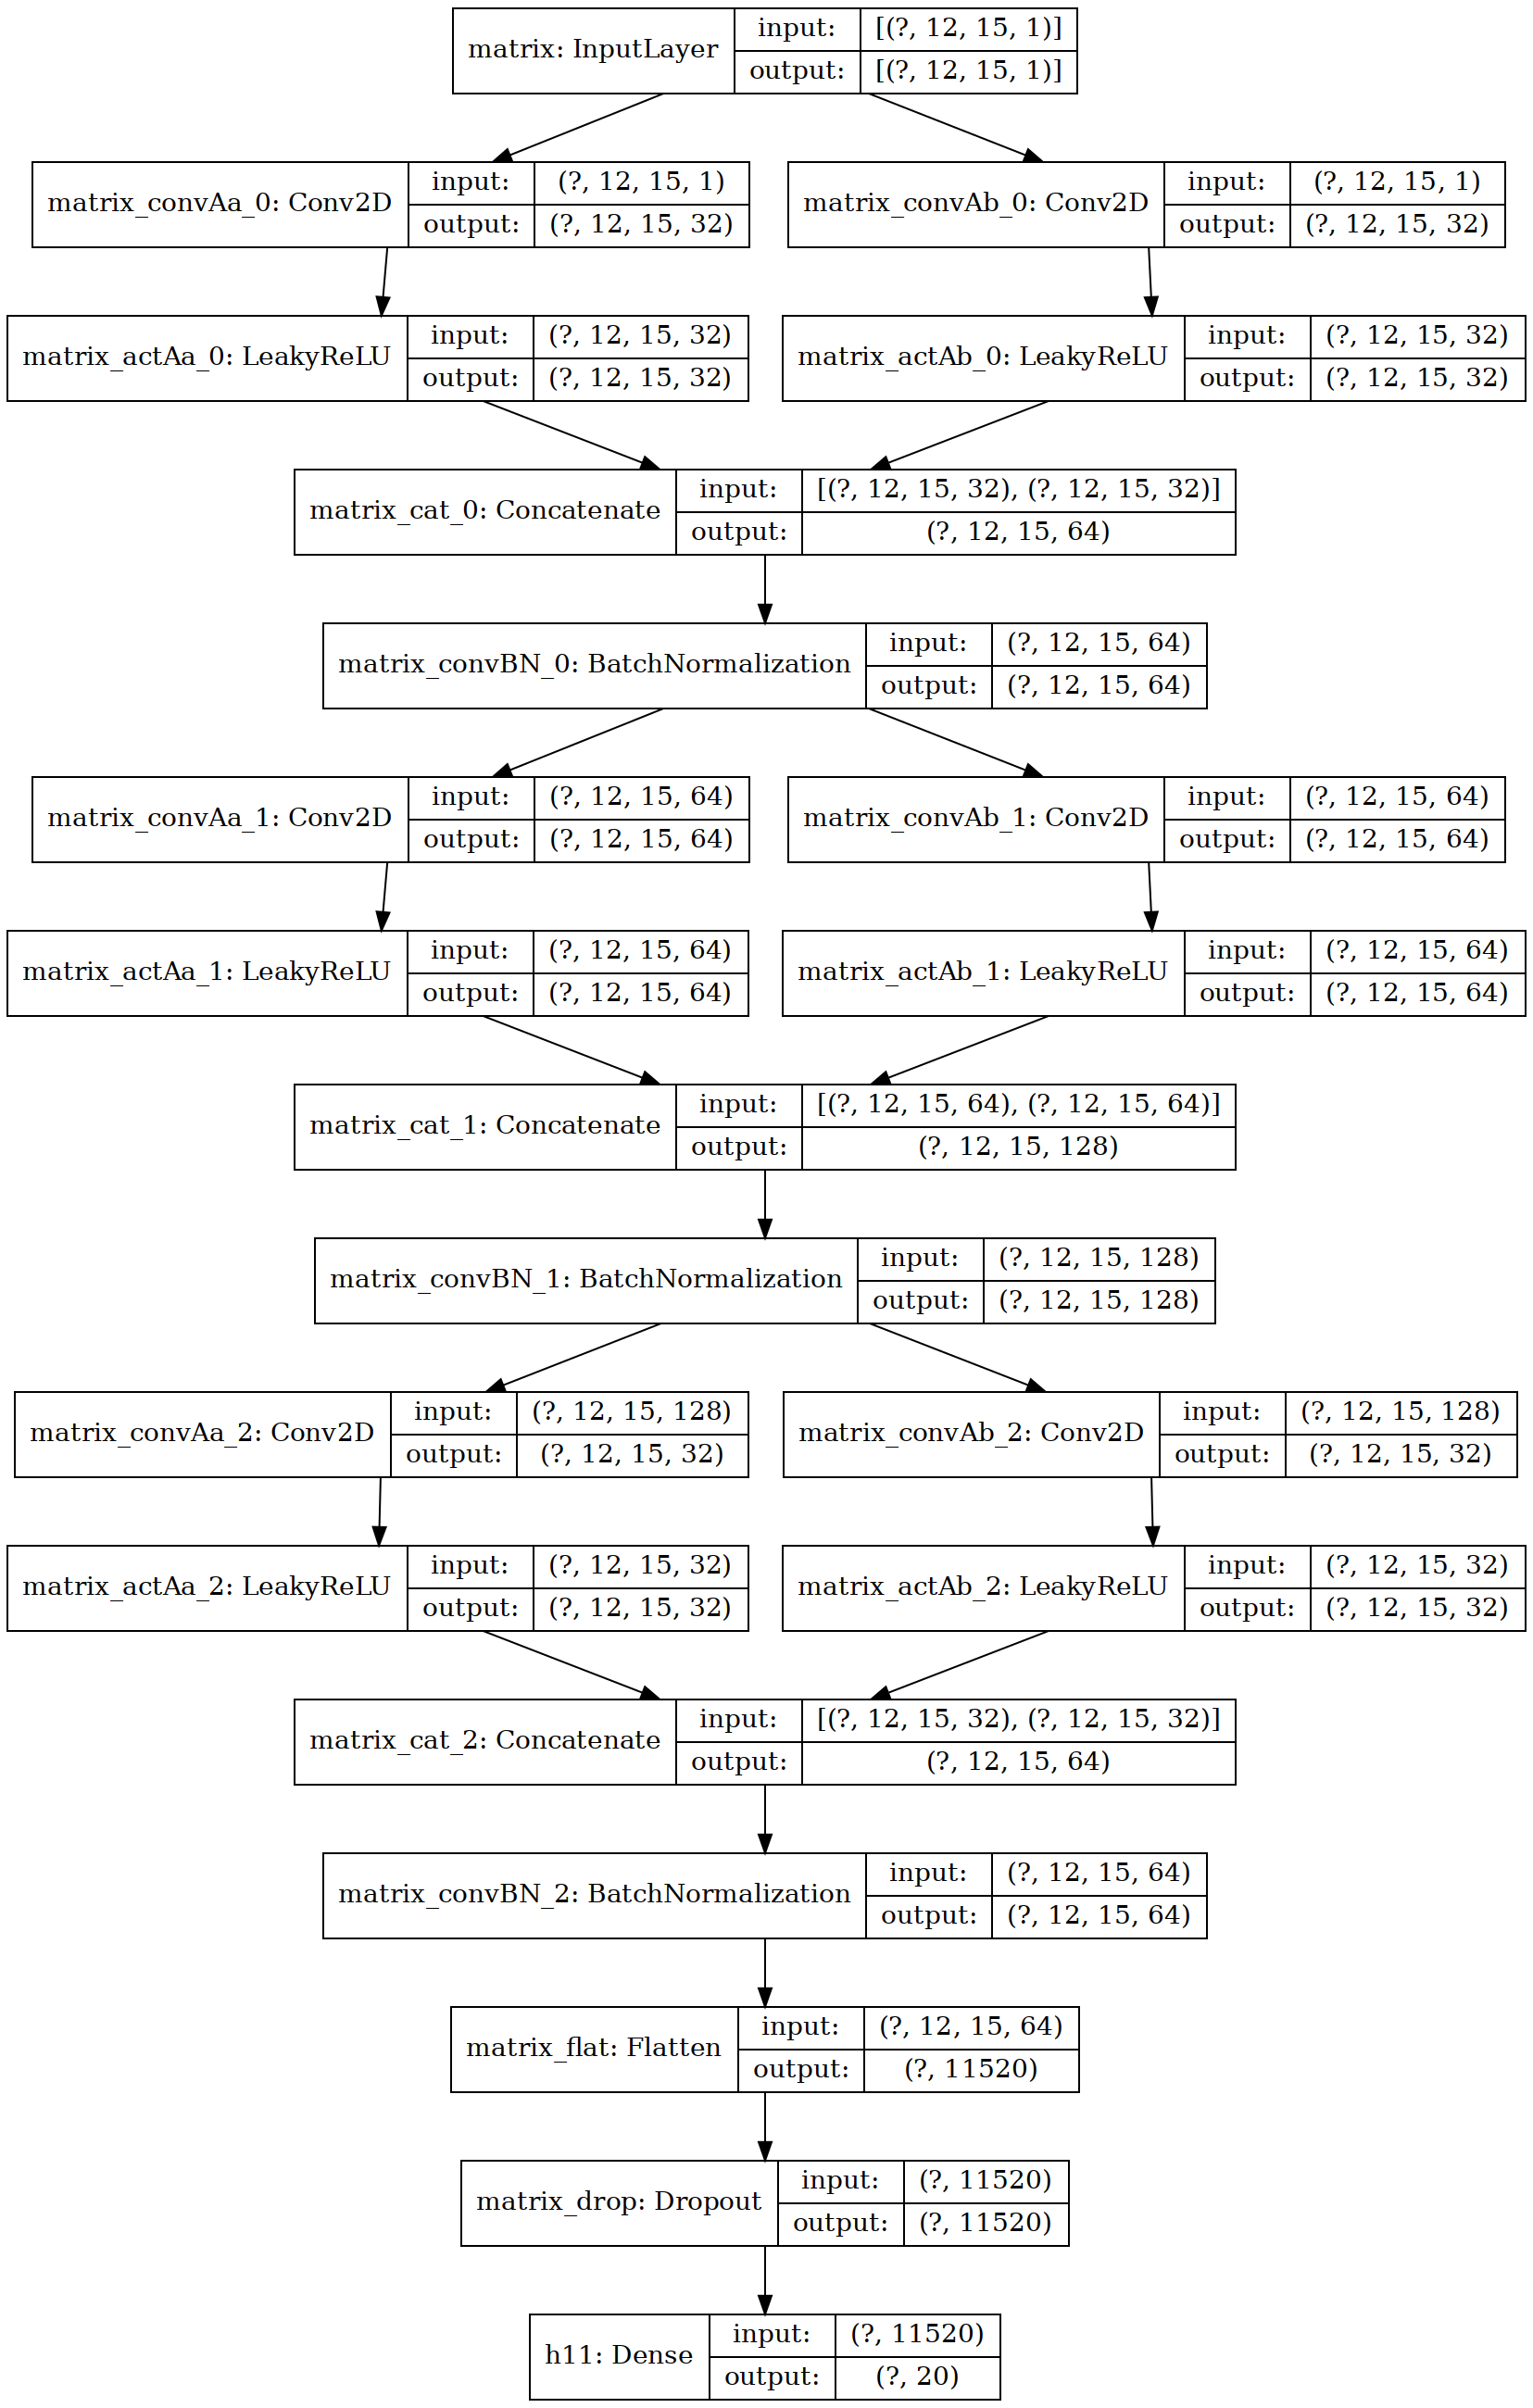

In [20]:
inception_graph = keras.utils.model_to_dot(inception, show_shapes=True, dpi=144)
inception_graph.write_pdf(os.path.join(img_dir, 'inception.pdf'))
Image(inception_graph.create_png(), width=480)

### Train the Model

In [21]:
fit_data = {'epochs':             1000,
            'batch_size':         32,
            'reduce_lr_factor':   0.3,
            'reduce_lr_patience': 350,
            'stat_interval':      100
           }

with open(os.path.join(mod_dir, 'fit_data.json'), 'w') as f:
    json.dump(fit_data, f)

In [22]:
callbacks = model_checkpoints(root=mod_dir,
                              validation=True,
                              reduce_lr=fit_data['reduce_lr_factor'],
                              lr_patience=fit_data['reduce_lr_patience'],
                              summary=fit_data['stat_interval']
                             )

inception_hst = inception.fit(x=X_train,
                              y=y_train,
                              batch_size=fit_data['batch_size'],
                              epochs=fit_data['epochs'],
                              verbose=0,
                              callbacks=callbacks,
                              validation_data=(X_val, y_val)
                             )

Training has started. Callouts will be printed every 100 epochs.

Training epoch 1. Started on 22/12/2020 at 09:57:37.

    Average epoch training time: 00 hours, 00 minutes, 30 seconds

    loss = 3.482420
    categorical_accuracy = 0.499153
    val_loss = 3.094943
    val_categorical_accuracy = 0.326972
    lr = 0.001000

Training epoch 100. Started on 22/12/2020 at 09:59:32.

    Average epoch training time: 00 hours, 00 minutes, 15 seconds

    loss = 0.361613
    categorical_accuracy = 0.994492
    val_loss = 2.901649
    val_categorical_accuracy = 0.755725
    lr = 0.001000

Training epoch 200. Started on 22/12/2020 at 10:00:59.

    Average epoch training time: 00 hours, 00 minutes, 10 seconds

    loss = 0.230089
    categorical_accuracy = 0.998305
    val_loss = 2.748329
    val_categorical_accuracy = 0.755725
    lr = 0.001000

Training epoch 300. Started on 22/12/2020 at 10:02:26.

    Average epoch training time: 00 hours, 00 minutes, 08 seconds

    loss = 0.212354
    cat

## Visualisation of the Training Data

We plot the metrics and the loss of the training for reference.

In [23]:
inception_hst = pd.DataFrame(inception_hst.history)
inception_hst.to_json(os.path.join(mod_dir, 'history.json'), orient='index')

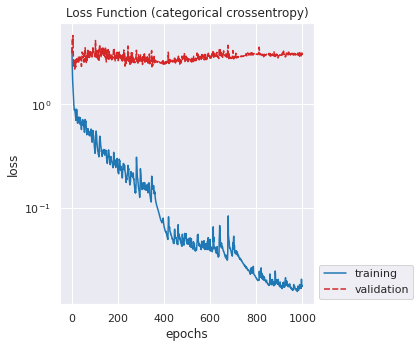

In [24]:
plot_loss(os.path.join(mod_dir, 'history.json'),
          out_name='inception_loss',
          root=img_dir,
          validation=True,
          title='Loss Function (categorical crossentropy)',
          yscale='log',
          base_ratio=(1,1),
          show=True,
          save_pdf=True
         )

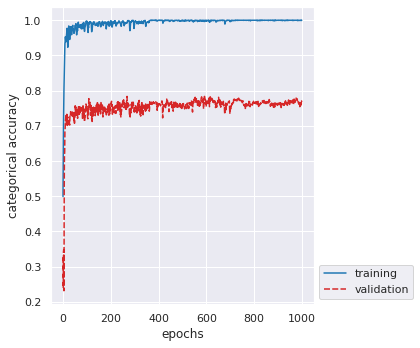

In [25]:
plot_metric(os.path.join(mod_dir, 'history.json'),
            metric='categorical_accuracy',
            out_name='cat_acc',
            root=img_dir,
            validation=True,
            title='',
            ylabel='categorical accuracy',
            yscale=None,
            base_ratio=(1,1),
            show=True,
            save_pdf=True
           )

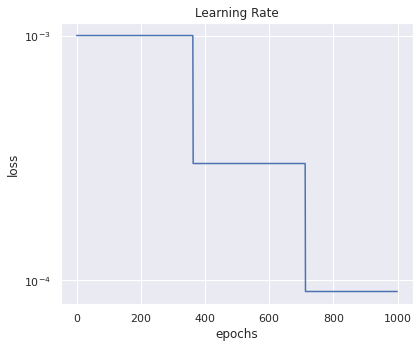

In [26]:
plot_lr(os.path.join(mod_dir, 'history.json'),
        out_name='inception_lr',
        root=img_dir,
        show=True,
        save_pdf=True
       )

## Test Predictions

We finally compute the predictions on the test set.

In [27]:
model = keras.models.load_model(os.path.join(mod_dir, 'val_loss.h5'))

In [28]:
y_pred = model.predict(X_test)
y_pred = {key: value.argmax(axis=1) for key, value in y_pred.items()}
y_true = {key: value.argmax(axis=1) for key, value in y_test.items()}

In [29]:
test_accuracy = {key: np.mean(np.equal(y_pred[key], y_true[key])) for key in y_true.keys()}
for key in test_accuracy.keys():
    print('Test set accuracy:\n')
    print(f'  {key}: {test_accuracy[key]:.3f}')

Test set accuracy:

  h11: 0.737


In [30]:
with open(os.path.join(mod_dir, 'test_accuracy.json'), 'w') as f:
    json.dump(test_accuracy, f)